In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
# 导入相关库
import numpy as np
import matplotlib.pyplot as plt
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 加载研究区域
roi = ee.FeatureCollection('users/311605001111/YangtzeCity/wuhan').geometry()
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

# 加载样本集
samples = ee.FeatureCollection('users/311605001111/saample_wuhan2018')
# Map.addLayer(samples, {}, "WuhanTrainingPoints_2020")
print(samples.size().getInfo())

## 在样本集中，各类样本的个数
# clt_water = samples.filter(ee.Filter.eq('waterclass',1))
# print(clt_water.size().getInfo())
# clt_nowater = samples.filter(ee.Filter.eq('waterclass',0))
# print(clt_nowater.size().getInfo())

2154


In [6]:
## 加载影像

# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)
# landsat影像可视化参数
visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2018-12-31') \
    .map(maskL8sr)
Map.addLayer(landsat_images.mosaic().clip(roi),visParams,'landsat image')

# 计算筛选后的样本集

In [7]:
# K_mean聚类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
clusterer = ee.Clusterer.wekaKMeans(2).train(samples,bands)
result = samples.cluster(clusterer)

print(result.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [114.2550334958226, 30.706413283674824]}, 'id': '00000000000000000354', 'properties': {'AWEI': -3717.25, 'B2': 908, 'B3': 1163, 'B4': 1315, 'B5': 2545, 'B6': 2203, 'B7': 1643, 'Image_id': 'LC08_123039_20180408', 'NDVI': 0.318652849740933, 'cluster': 0, 'mNDWI': -0.308972073677956, 'ndvi_mndwi': 0.627624923418889, 'waterclass': 0}}


In [8]:
#聚类后的水体
clt_water = result.filter(ee.Filter.eq('cluster',0))
print("聚类后的水体样本个数：",clt_water.size().getInfo())
# Map.addLayer(clt_water,{'color': '7CFC00', 'pointSize': 4,'fillColor': '7CFC00'},"clt_water")
#聚类后的非水体
clt_nowater = result.filter(ee.Filter.eq('cluster',1))
print("聚类后的非水体样本个数：",clt_nowater.size().getInfo())
# Map.addLayer(clt_nowater,{'color': 'f40101ff', 'pointSize': 4,'fillColor': 'ef0b0b56'},"clt_nowater")

聚类后的水体样本个数： 1207
聚类后的非水体样本个数： 947


In [9]:
# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft


right = result.map(Compare).filter(ee.Filter.eq('eq',0))
print(right.size().getInfo())
# Map.addLayer(right,{'color': 'FF8C00', 'pointSize': 4,'fillColor': 'FF8C00'},"right")

error = result.map(Compare).filter(ee.Filter.eq('eq',1))
print(error.size().getInfo())
# Map.addLayer(error,{'color': 'FF00FF', 'pointSize': 4,'fillColor': 'FF00FF'},"error")

164
1990


In [10]:
# 过滤后的样本
filtered_sample = ee.Algorithms.If(right.size().gt(error.size()),right,error)
print("筛选后，剩余的样本数： ",ee.FeatureCollection(filtered_sample).size().getInfo())

land = ee.FeatureCollection(filtered_sample).filter(ee.Filter.eq('waterclass',0))
print("筛选后样本中，非水体的个数： ",land.size().getInfo())
water = ee.FeatureCollection(filtered_sample).filter(ee.Filter.eq('waterclass',1))
print("筛选后样本中，水体的个数： ",water.size().getInfo())

筛选后，剩余的样本数：  1990
筛选后样本中，非水体的个数：  1200
筛选后样本中，水体的个数：  790


# 全部样本

2154


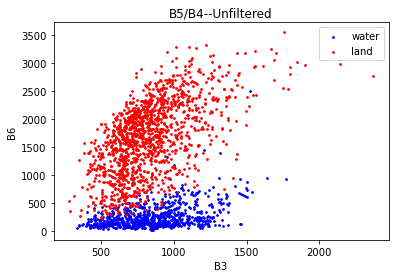

In [23]:
# 样本总数
print(samples.size().getInfo())
x = 'B3'
y = 'B6'
# 全部样本
land_x = np.array(samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y = np.array(samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x = np.array(samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y = np.array(samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 

plt.figure()
plt.scatter(water_x,water_y,s=3,c='blue', label = 'water')
plt.scatter(land_x,land_y,s=3,c='red', label = 'land')
plt.xlabel(x)    
plt.ylabel(y)
plt.title('B5/B4--Unfiltered') 
plt.legend()
plt.show()

2154


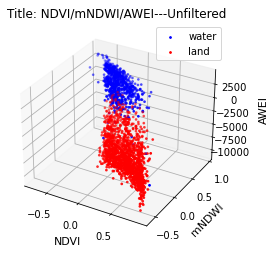

In [12]:
## 数据
# 样本总数
print(samples.size().getInfo())
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x =np.array(samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(samples.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(samples.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'land')  
# 坐标轴
ax.set_xlabel(x,fontsize = 11)
ax.set_ylabel(y,fontsize = 11)
ax.set_zlabel(z,labelpad = 10,rotation=90,fontsize = 11)
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/mNDWI/AWEI---Unfiltered') 
plt.legend(loc='upper right')
plt.show()

# 筛选后的样本

1990


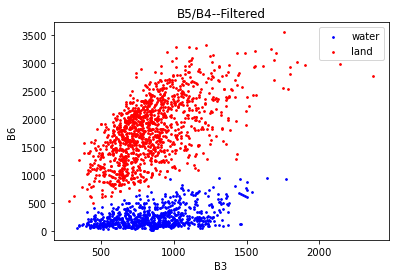

In [24]:
# 样本总数
filtered_sample = ee.FeatureCollection(filtered_sample)
print(filtered_sample.size().getInfo())
x = 'B3'
y = 'B6'
# 全部样本
land_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo())
land_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
water_x = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y = np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 

plt.figure()
plt.scatter(water_x,water_y,s=3,c='blue', label = 'water')
plt.scatter(land_x,land_y,s=3,c='red', label = 'land')
plt.xlabel(x)    
plt.ylabel(y)
plt.title('B5/B4--Filtered') 
plt.legend()
plt.show()

1990


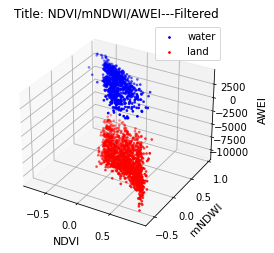

In [14]:
## 数据
# 样本总数
filtered_sample = ee.FeatureCollection(filtered_sample)
print(filtered_sample.size().getInfo())
x = 'NDVI'
y = 'mNDWI'
z = 'AWEI'
# 全部样本
land_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(x).getInfo()) 
land_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(y).getInfo()) 
land_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',0)).aggregate_array(z).getInfo()) 
water_x =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(x).getInfo()) 
water_y =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(y).getInfo()) 
water_z =np.array(filtered_sample.filter(ee.Filter.eq('waterclass',1)).aggregate_array(z).getInfo()) 

# 创建一个三维的绘图工程
ax = plt.subplot(111, projection='3d')  
# 绘制数据点
ax.scatter(water_x, water_y, water_z, s=3, c='blue', label = 'water')
ax.scatter(land_x, land_y, land_z, s=3,c='red', label = 'land')  
# 坐标轴
ax.set_xlabel(x,fontsize = 11)
ax.set_ylabel(y,fontsize = 11)
ax.set_zlabel(z,labelpad = 10,rotation=90,fontsize = 11)
plt.yticks([-0.5,0,0.5,1.0])
plt.title('Title: NDVI/mNDWI/AWEI---Filtered') 
plt.legend(loc='upper right')
plt.show()

# 附录

In [ ]:
## 未经过K_mean聚类
# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(samples,label,bands)

train_accuracy = trainedClassifier.confusionMatrix()
print(train_accuracy.getInfo())
print(train_accuracy.accuracy().getInfo())
print(train_accuracy.kappa().getInfo())

In [ ]:
## 经过K_mean聚类
# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_sample,label,bands)

train_accuracy = trainedClassifier.confusionMatrix()
print(train_accuracy.getInfo())
print(train_accuracy.accuracy().getInfo())
print(train_accuracy.kappa().getInfo())

In [ ]:
## 样本聚类（K_mean），代码重点内容
# “samples”为样本集
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
clusterer = ee.Clusterer.wekaKMeans(2).train(samples,bands)
result = samples.cluster(clusterer)

# cluster与waterclass的对比
def Compare(feature):
    cluster = ee.Number(feature.get('cluster'))
    waterclass = ee.Number(feature.get('waterclass'))
    ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
    return ft

# 下面二选一
right = result.map(Compare).filter(ee.Filter.eq('eq',0))
error = result.map(Compare).filter(ee.Filter.eq('eq',1))
# 过滤后的样本
filtered_sample = ee.Algorithms.If(right.size().gt(error.size()),right,error)

# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','AWEI']
# 分类标签
label = 'waterclass'
# RF训练
trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_sample,label,bands)

In [ ]:
## 定义一个函数，从要素中移除一个属性
# k_means聚类
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI','mNDWI', 'AWEI']
# Generic Function to remove a property from a feature
def removeProperty(feat):
    selectProperties = ee.Feature(feat).propertyNames().filter(ee.Filter.neq('item', 'waterclass'))
    return feat.select(selectProperties)
samples = ee.FeatureCollection('users/311605001111/WuhanTrainingPoints_2020')
a = samples.first()
print(a.getInfo())
print(removeProperty(ee.Feature(a)).getInfo())
